# Decoding stimulus identity from neural responses

We implement here a nearest-neighbor decoder of neural activity.

In [1]:
# general modules
import pynwb, os, sys
import numpy as np
import matplotlib.pylab as plt

# custom modules
sys.path.append('..')
from physion.analysis.read_NWB import read as read_NWB
from physion.analysis.trial_averaging import build_episodes
from physion.visual_stim.psychopy_code.stimuli import build_stim


# we define a data object fitting this analysis purpose
class Data:
    def __init__(self, filename, verbose=False):
        """ opens data file """
        read_NWB(self, filename, verbose=verbose, with_visual_stim=True)
        
class PatternResponses:
    
    def __init__(self, data,
                 protocol_id=0,
                 quantity='CaImaging', 
                 subquantity='Fluorescence',
                 nmax_ROI = 10000, # to limit the number of ROIs
                 verbose=False):
        """ build the patterns for the different inputs of a protocol"""
        for key in data.__dict__.keys():
            setattr(self, key, getattr(data, key))
        if verbose:
            print('Building episodes for "%s"' % self.protocols[protocol_id])
        data.CaImaging_key, EPISODES = subquantity, []
        # looping over cells, we get the episode responses
        for roi in range(np.sum(data.iscell))[:nmax_ROI]:
            data.roiIndices = [roi] 
            EPISODES.append(build_episodes(data, protocol_id=protocol_id,
                                           quantity=quantity, verbose=False))
        # now looping over conditions to build the pattern responses
        KEYS = data.varied_parameters.keys()
        VALUES = [v.flatten() for v in np.meshgrid(*[data.varied_parameters[k] for k in KEYS])]
        STIM = {}
        setattr(self, 'resp', [])
        for key in KEYS:
            STIM[key] = []
        for i in range(len(VALUES[0])):
            # looping over unique stimuli
            cond = np.ones(len(EPISODES[0]['resp']), dtype=bool)
            for key, values in zip(KEYS, VALUES):
                cond = cond & (EPISODES[0][key]==values[i])
                STIM[key].append(values[i])
            # now building the set of repeated pattern for a unique stim
            for icond in np.arange(len(EPISODES[0]['resp']))[cond]:
                pattern = np.zeros((len(EPISODES), len(EPISODES[0]['resp'][0]))) # shape (ROI, time)
                for roi, episodes in enumerate(EPISODES):
                    pattern[roi,:] = episodes['resp'][icond]
                getattr(self, 'resp').append(pattern)
        setattr(self, 'stim', STIM)
        setattr(self, 't', EPISODES[0]['t']) # time array corresponding to the patterns

filename = os.path.join(os.path.expanduser('~'), 'DATA', 'Wild_Type', '2021_03_19-14-51-17.nwb')
data = Data(filename)
patterns = PatternResponses(data, protocol_id=2,
                            quantity='CaImaging', 
                            subquantity='dF/F',
                            nmax_ROI=10)

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
processed quantities of Pupil dynamics
Adapting image to chosen screen resolution [...]
Performing histogram normalization [...]
Adapting image to chosen screen resolution [...]
Performing histogram normalization [...]
Adapting image to chosen screen resolution [...]
Performing histogram normalization [...]
Adapting image to chosen screen resolution [...]
Performing histogram normalization [...]
Adapting image to chosen screen resolution [...]
Performing histogram normalization [...]
Adapting image to chosen screen resolution [...]
Performing histogram normalization [...]


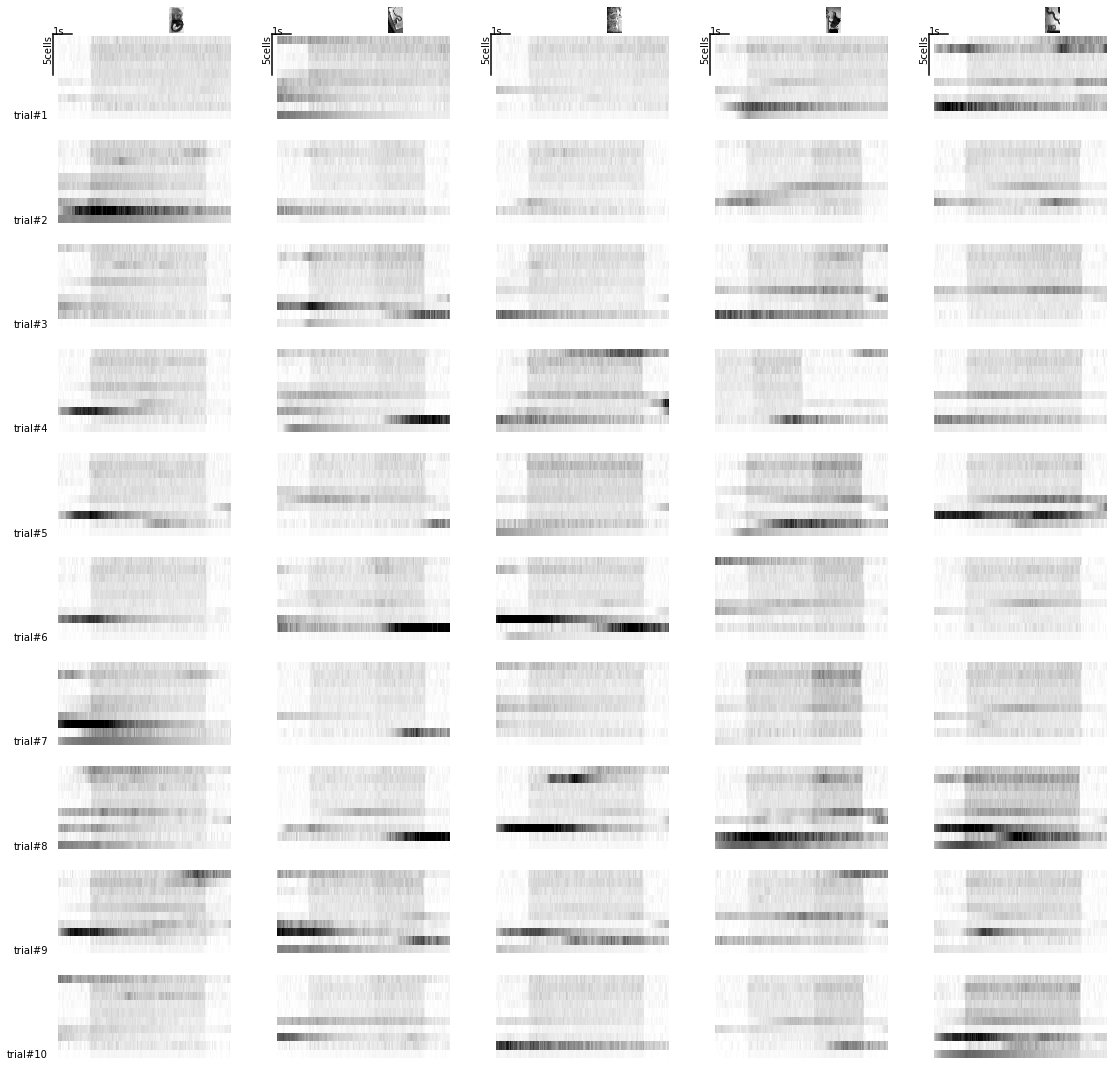

In [2]:
def show_pattern(self, i, ax=None, tlim=None, Tsubsampling=10, 
                 annotations = dict(Tbar=1, Rbar=5), space=0.03, rm_annot=False):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(3,1.8))
    if tlim is None:
        tlim = [self.t[0], self.t[-1]]
    dT, dN = (tlim[1]-tlim[0]), self.resp[i].shape[0]
    ax.imshow(self.resp[i][:,::Tsubsampling], cmap=plt.cm.binary,
              aspect='auto', interpolation='none', vmin=0, vmax=10, origin='lower',
              extent = (*tlim, 0, dN))
    if (annotations is not None) and not rm_annot:
        ax.plot([tlim[0]-space*dT, tlim[0]-space*dT+annotations['Tbar']], np.ones(2)*dN*(1+space), 'k')
        ax.annotate('%ss' % annotations['Tbar'], (tlim[0]-space*dT, dN*(1+space)))
        ax.plot(tlim[0]*np.ones(2)-space*dT, -annotations['Rbar']*np.arange(2)+dN*(1+space), 'k')
        ax.annotate('%scells' % annotations['Rbar'], (tlim[0]-space*dT, dN*(1+space)), va='top', ha='right', rotation=90)
        
    ax.set_xlim([tlim[0]-2*space*dT, tlim[1]])
    ax.set_ylim([0, (1+2*space)*dN])
    ax.axis('off')
    return ax

fig, AX = plt.subplots(10, 5, figsize=(15,15))
plt.subplots_adjust(top=.95, left=.02, right=1., bottom=0.)
IDS = np.arange(1,6)
for ii, ID in enumerate(IDS):
    cond = (np.array(patterns.stim['Image-ID'])==ID) & (np.array(patterns.stim['VSE-seed'])==1.)
    axi = AX[0][ii].inset_axes([0.5, 0.99, 0.4, 0.3])
    
    data.visual_stim.show_frame(np.argwhere((data.nwbfile.stimulus['Image-ID'].data[:]==ID))[0][0],
                                    ax=axi, label=None)
    
    for ir, i in enumerate(np.arange(len(patterns.stim['repeat']))[cond]):
        show_pattern(patterns, i, tlim=[-1,8], rm_annot=(ir>0), ax=AX[ir][ID-1])
        if ID==1:
            AX[ir][ID-1].annotate('trial#%i' % (ir+1), (AX[ir][0].get_xlim()[0], 0), ha='right')

## Defining a distance metrics for CaImaging responses

In [5]:
def Distance(Pattern1, Pattern2):
    """
    should have the shape (ROI, time)
    """
    return np.sum((Pattern1-Pattern2)**2)

X1 = np.ones((3,10))
X2 = np.zeros((3,10))


Distance(X2,X1)

30.0